In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create reference to the file
database_path = Path("Resources/hawaii.sqlite")

In [5]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")
#conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()

Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()

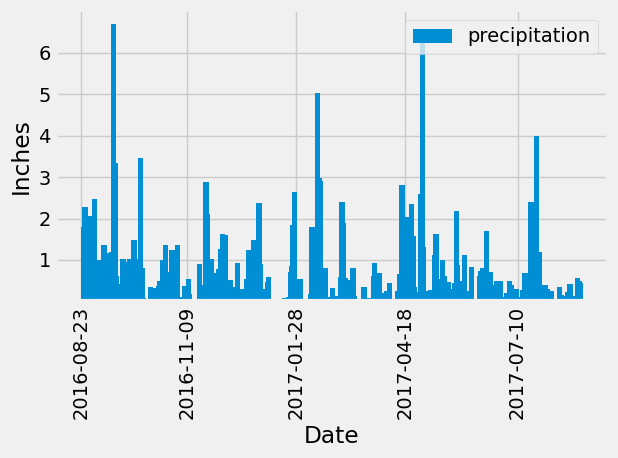

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precipitation_rows = session.query(measurement.date, measurement.prcp).\
                         filter(measurement.date >= query_date).\
                         order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_rows, columns = ['date', 'precipitation'])
precipitation_df.head()
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
x = precipitation_df['date']
y = precipitation_df['precipitation']
plt.bar(x,y, width = 4, align = 'edge')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(x[::500], rotation = 'vertical')
plt.yticks(range(1, 7))
plt.legend(['precipitation'])
plt.tight_layout()
plt.show()



In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station).count()
station_count

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station).\
                        group_by(measurement.station).\
                        order_by(func.count(measurement.tobs).desc()).first()

most_active = most_active_station[0]

temps = session.query(func.min(measurement.tobs),
                      func.max(measurement.tobs),
                      func.avg(measurement.tobs)).\
                filter(measurement.station == most_active).all()

print(temps)

[(54.0, 85.0, 71.66378066378067)]


In [16]:
#start with most recent in tobs
most_recent_tobs = session.query(measurement.tobs).\
                                filter(measurement.station== most_active).\
                                order_by(measurement.date.desc()).first()
most_recent_tobs

(79.0,)

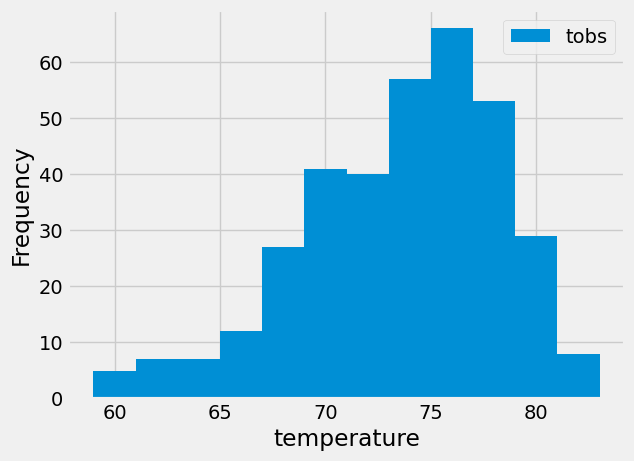

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_months = session.query(measurement.tobs).\
                        filter(measurement.station == most_active).\
                        filter(measurement.date >= query_date).all()

# Create a DataFrame out of the query
station_df = pd.DataFrame(station_months)

# Plot the data
station_df.plot.hist(bins = 12)
plt.xlabel("temperature")
plt.ylabel("Frequency")
plt.legend(['tobs'])
plt.show()



# Close Session

In [ ]:
# Close Session
session.close()